# Load packages

In [1]:
from metaspace import SMInstance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from deepims_clust import DeepClustering
from deepims_clust.utils import size_adaption, size_adaption_symmetric
from deepims_clust.cnnClust import CNNClust

import umap
%load_ext autoreload
%autoreload 2

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [2]:
evaluation_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_01h01m06s'
                  ]

In [3]:
training_results = {}
training_images = {}
training_if = {}
polarity = '+'

sm = SMInstance()

for k in evaluation_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    training_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    training_images[k] = tmp
    training_if[k] = formula

100%|████████████████████████████████████████| 241/241 [00:01<00:00, 203.58it/s]


# Data preprocessing

In [4]:
[x.shape for x in training_images.values()]

[(245, 74, 84),
 (221, 88, 88),
 (194, 41, 78),
 (237, 56, 85),
 (276, 71, 82),
 (201, 35, 55),
 (186, 60, 44)]

In [5]:
padding_images = size_adaption_symmetric(training_images)
[x.shape for x in padding_images.values()]

[(245, 88, 88),
 (221, 88, 88),
 (194, 88, 88),
 (237, 88, 88),
 (276, 88, 88),
 (201, 88, 88),
 (186, 88, 88)]

In [6]:
tst = set(training_if['2022-12-07_02h13m50s']).intersection(set(training_if['2022-12-07_02h13m20s']), 
                                                          set(training_if['2022-12-07_02h10m45s']), 
                                                          set(training_if['2022-12-07_02h09m41s']), 
                                                          set(training_if['2022-12-07_02h08m52s']), 
                                                          set(training_if['2022-12-07_01h02m53s']), 
                                                          set(training_if['2022-12-07_01h01m06s']))

In [7]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 126


# Preparing data

In [8]:
training_dsid = [
    '2022-12-07_01h01m06s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_02h13m50s'
                  ]

testing_dsid = [
    
]

In [9]:
training_data = []
training_datasets = [] 
training_ions = []

testing_data = []
testing_datasets = [] 
testing_ions = []


for dsid, imgs in padding_images.items():
    
    if dsid in training_dsid:
        training_data.append(imgs)
        training_datasets += [dsid] * imgs.shape[0]
        training_ions += training_if[dsid]
    
    testing_data.append(imgs)
    testing_datasets += [dsid] * imgs.shape[0]
    testing_ions += training_if[dsid]
        
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

testing_data = np.concatenate(testing_data)
testing_datasets = np.array(testing_datasets)
testing_ions = np.array(testing_ions)

# Activation comparison

## Softmax

In [10]:
model_softmax = DeepClustering(
                                images=training_data,
                                dataset_labels=training_datasets,
                                ion_labels=training_ions,
                                num_cluster=8,
                                initial_upper=93,
                                initial_lower=37,
                                upper_iteration=1.5,
                                lower_iteration=1.5,
                                dataset_specific_percentiles=True,
                                random_flip=True,
                                knn=True, k=5,
                                lr=0.0001, batch_size=128,
                                pretraining_epochs=11,
                                training_epochs=16,
                                cae_encoder_dim=20,
                                use_gpu=True,
                                activation='softmax',
                                overweight_cae=0.5,
                                random_seed=1225
                            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [11]:
model_softmax.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.019428
Pretraining Epoch: 1 Loss: 0.009514
Pretraining Epoch: 2 Loss: 0.007926
Pretraining Epoch: 3 Loss: 0.007533
Pretraining Epoch: 4 Loss: 0.007298
Pretraining Epoch: 5 Loss: 0.007086
Pretraining Epoch: 6 Loss: 0.006960
Pretraining Epoch: 7 Loss: 0.006881
Pretraining Epoch: 8 Loss: 0.006775
Pretraining Epoch: 9 Loss: 0.006721
Pretraining Epoch: 10 Loss: 0.006695
Training Epoch: 0 | CAE-Loss: 0.073782 | CNN-Loss: 0.306337 | Total loss: 0.343228
Training Epoch: 1 | CAE-Loss: 0.032562 | CNN-Loss: 0.122131 | Total loss: 0.138412
Training Epoch: 2 | CAE-Loss: 0.030293 | CNN-Loss: 0.097479 | Total loss: 0.112626
Training Epoch: 3 | CAE-Loss: 0.029933 | CNN-Loss: 0.097904 | Total loss: 0.112870
Training Epoch: 4 | CAE-Loss: 0.030016 | CNN-Loss: 0.081426 | Total loss: 0.096434
Training Epoch: 5 | CAE-Loss: 0.030317 | CNN-Loss: 0.085422 | Total loss: 0.100581
Training Epoch: 6 | CAE-Loss: 0.029874 | CNN-Los

0

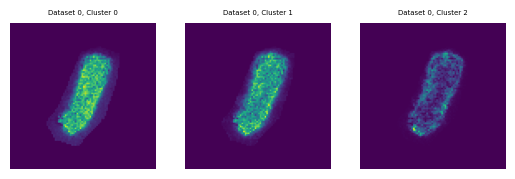

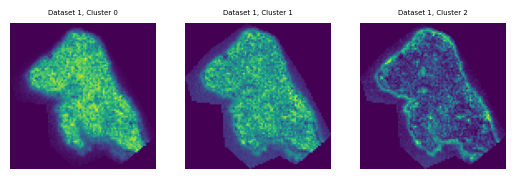

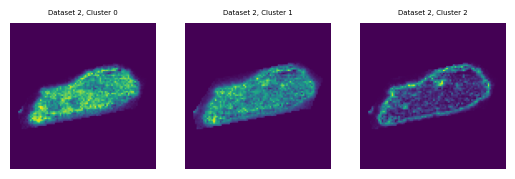

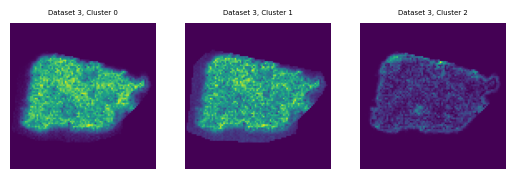

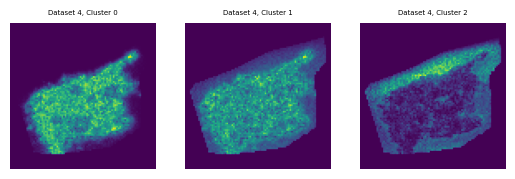

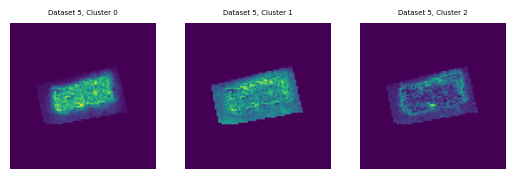

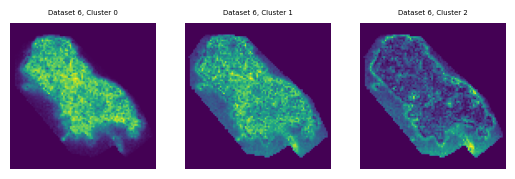

In [13]:
pred_labels1 = model_softmax.inference()

# Loop over datasets:
ds_counter = 0
for ds in training_dsid:
    
    ds_imgs = model_softmax.image_data[model_softmax.dataset_labels==ds]
    curr_labels = pred_labels1[model_softmax.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels1):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(pred_labels1)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1


## ReLU

In [29]:
model_relu = DeepClustering(
                            images=training_data,
                            dataset_labels=training_datasets,
                            ion_labels=training_ions,
                            num_cluster=8,
                            initial_upper=93,
                            initial_lower=37,
                            upper_iteration=1.5,
                            lower_iteration=1.5,
                            dataset_specific_percentiles=True,
                            random_flip=True,
                            knn=True, k=5,
                            lr=0.0001, batch_size=128,
                            pretraining_epochs=10,
                            training_epochs=16,
                            cae_encoder_dim=20,
                            use_gpu=True,
                            activation='relu',
                            clip_gradients=.4,
                            overweight_cae=0.5,
                            random_seed=np.random.randint(0, 10000)
                            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [30]:
model_relu.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.022133
Pretraining Epoch: 1 Loss: 0.009686
Pretraining Epoch: 2 Loss: 0.008142
Pretraining Epoch: 3 Loss: 0.007802
Pretraining Epoch: 4 Loss: 0.007541
Pretraining Epoch: 5 Loss: 0.007324
Pretraining Epoch: 6 Loss: 0.007062
Pretraining Epoch: 7 Loss: 0.006880
Pretraining Epoch: 8 Loss: 0.006776
Pretraining Epoch: 9 Loss: 0.006679
Training Epoch: 0 | CAE-Loss: 0.037221 | CNN-Loss: 0.224998 | Total loss: 0.243609
Training Epoch: 1 | CAE-Loss: 0.030035 | CNN-Loss: 0.050778 | Total loss: 0.065795
Training Epoch: 2 | CAE-Loss: 0.028575 | CNN-Loss: 0.049891 | Total loss: 0.064178
Training Epoch: 3 | CAE-Loss: 0.029889 | CNN-Loss: 0.534791 | Total loss: 0.549736
Training Epoch: 4 | CAE-Loss: 0.031123 | CNN-Loss: 0.103245 | Total loss: 0.118806
Training Epoch: 5 | CAE-Loss: 0.030519 | CNN-Loss: 0.061919 | Total loss: 0.077178
Training Epoch: 6 | CAE-Loss: 0.030732 | CNN-Loss: 0.073299 | Total loss: 0.088665
Tr

0

## Sigmoid

In [11]:
model_sigmoid = DeepClustering(
                                images=training_data,
                                dataset_labels=training_datasets,
                                ion_labels=training_ions,
                                num_cluster=8,
                                initial_upper=93,
                                initial_lower=37,
                                upper_iteration=1.5,
                                lower_iteration=1.5,
                                dataset_specific_percentiles=True,
                                random_flip=True,
                                knn=True, k=5,
                                lr=0.0001, batch_size=128,
                                pretraining_epochs=11,
                                training_epochs=16,
                                cae_encoder_dim=20,
                                use_gpu=True,
                                activation='sigmoid',
                                random_seed=1225
                            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [ ]:
model_sigmoid.train()